### This is the code to implement feature selection methods
#### References:
- Agrawal, S. (2023, June 6). Feature Selection Using Lasso Regression. Medium. https://medium.com/@agrawalsam1997/feature-selection-using-lasso-regression-10f49c973f08.  
Contribution: General understanding of the Lasso Regression method.
- Gomede, E. (2024, March 9). RFE Recursive Feature Elimination: A Powerful Technique for Feature Selection in Machine Learning. The Modern Scientist. https://medium.com/the-modern-scientist/recursive-feature-elimination-a-powerful-technique-for-feature-selection-in-machine-learning-89b3c2f3c26a.  
Contribution: General understanding of the RFE method.

#### Libraries:
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html - - Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830.
- Package statsmodels (0.14). (2024). [Python]. statsmodels. https://github.com/statsmodels/statsmodels

In [1]:
# Importing libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL

In [2]:
# Importing the original dataset
df_raw = pd.read_csv('../data/df_merged.csv')

# Let's drop some columns that are not useful for our analysis, due to causal relationships or to the existence of duplicated information
columns_to_drop = ['ECO_fiscal_result_12months', 'ECO_inflation_12months','ECO_gross_debt_gdp_pre', 'ECO_gross_debt_gdp_pos',
       'ECO_gross_debt_R$_pre', 'ECO_gross_debt_R$_pos', 'ECO_net_debt_gdp_%',
       'ECO_net_debt_R$', 'ECO_net_debt_gdp_%_federal_govt',
       'ECO_net_debt_R$_federal_govt', 'ECO_net_debt_R$_dlspc']

# Dropping columns
df_raw.drop(columns_to_drop, axis=1, inplace=True)

# Rename a column
df_raw.rename(columns={"Euro area (19 countries)":"WD_Euro area (19 countries)"}, inplace=True)

# Setting date as index
df_raw.set_index('Date', inplace=True)

# Convert the index as date
df_raw.index = pd.to_datetime(df_raw.index)

# Set the taret variable
target_variable = df_raw.columns[0]

# Convert all columns to float
df_raw = df_raw.astype(float)

df_raw.to_csv('../data/data_orig_parameters.csv', index=True)

### Exploratory Data Analysis - EDA

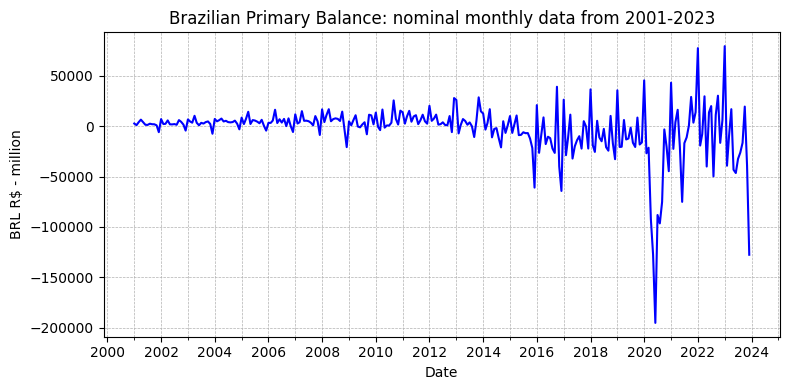

In [11]:
# Let's evaluate the series

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(df_raw.index, df_raw[target_variable], color='blue')

# Format the plot
plt.title('Brazilian Primary Balance: nominal monthly data from 2001-2023')
plt.xlabel('Date')
plt.ylabel('BRL R$ - million')
plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Add grid

# Set major and minor ticks format
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))   # Every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))   # Every year for minor ticks

# Show the plot
plt.tight_layout()
plt.show()


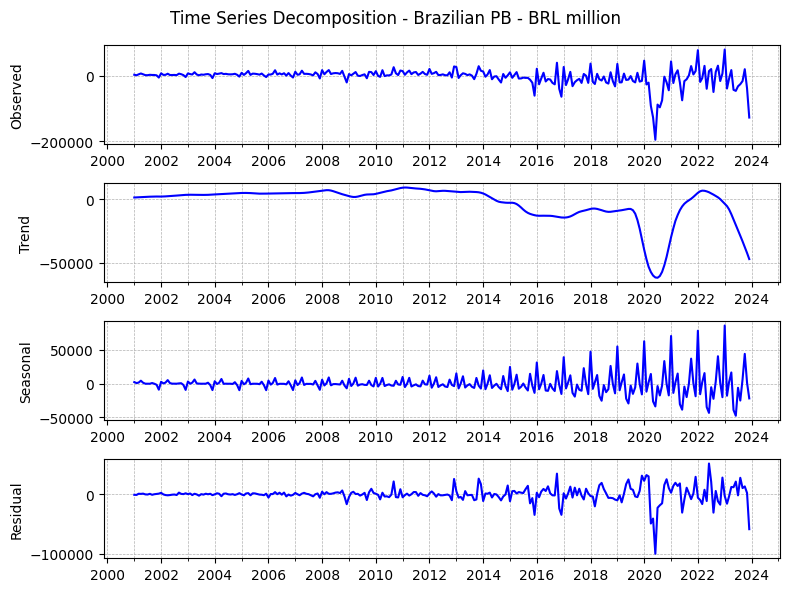

In [4]:
# Decompose time series
stl = STL(df_raw[target_variable], seasonal=13) # Seasonal is 13 months as the data is monthly and the number must be odd
result = stl.fit() # Fit the model

# Function to configure the axes
def configure_axes(ax, title, rotation=90):
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))

# Define the components
components = [('Observed', result.observed), 
              ('Trend', result.trend), 
              ('Seasonal', result.seasonal), 
              ('Residual', result.resid)]

# Plot the components
plt.figure(figsize=(8, 6))
plt.suptitle('Time Series Decomposition - Brazilian PB - BRL million', fontsize=12) # Title

# For each component, plot the data
for i, (title, component) in enumerate(components):
    ax = plt.subplot(4, 1, i+1) # Create a subplot and set´s its position
    ax.plot(component, color='blue')
    ax.set_ylabel(title) # Show the name of the component
    configure_axes(ax, title)

plt.tight_layout()
plt.show()


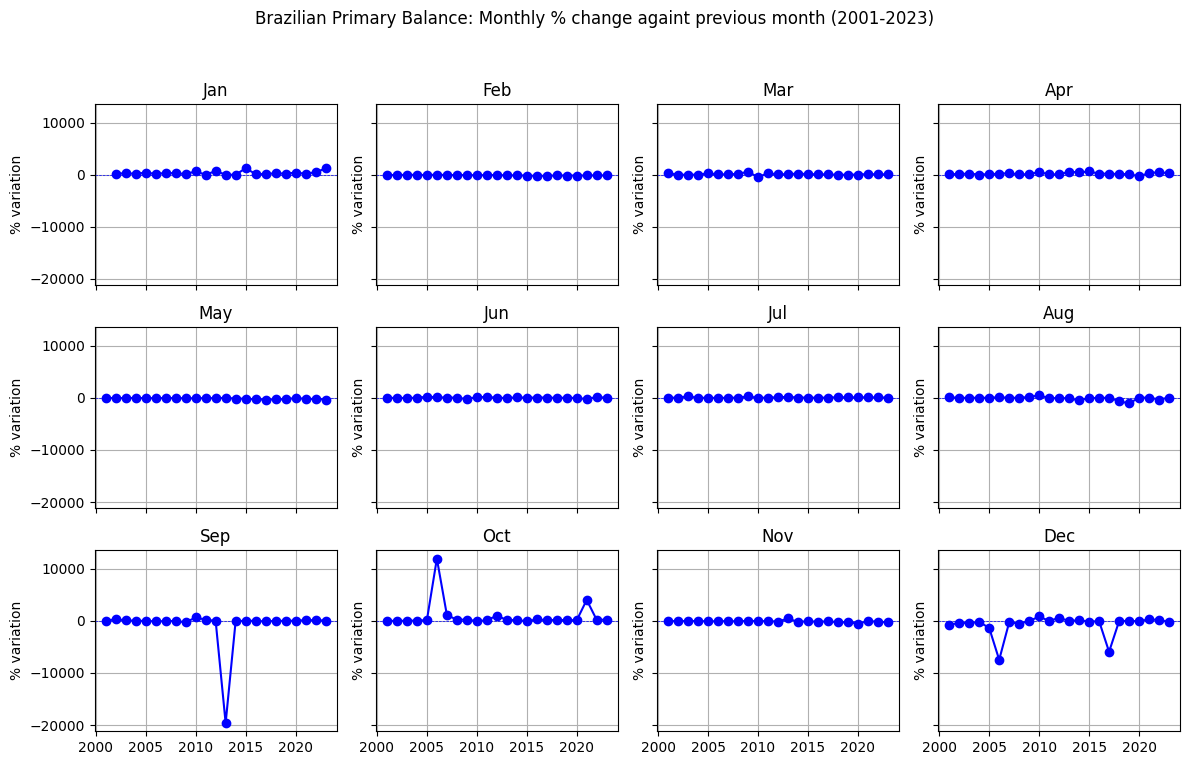

In [5]:
### Let´s evaluate the seasonality of the series checking the historical monthly variation
# Create a copy of the original dataset
df_pct = df_raw[[target_variable]].copy()

# Convert the index as date
df_pct.index = pd.to_datetime(df_pct.index)

# Function to calculate the percentage variation between the month and its predecessor
def custom_variation(current, previous):
    # Mask for negative values
    mask_negative = previous < 0
    
    # Create a series with the same length as the current series to store the variation
    variation = pd.Series(np.zeros(len(current)), index=current.index)
    
    # Calculate the percentage variation where the previous value is negative
    variation[mask_negative] = (current[mask_negative] - previous[mask_negative]) / abs(previous[mask_negative]) * 100
    
    # Calculate the percentage variation where the previous value is positive
    variation[~mask_negative] = (current[~mask_negative] - previous[~mask_negative]) / previous[~mask_negative] * 100
    
    return variation

# Apply the function to calculate the percentage variation
df_pct['PB_variation'] = custom_variation(df_pct[target_variable], df_pct[target_variable].shift(1)) # shift(1) is the previous month

# To remove outliers, let's replace values bigget than 3000% by NaN
df_pct.loc[abs(df_pct['PB_variation']) > 30000, 'PB_variation'] = np.nan

# Plot 12 subplots, one for each month
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle('Brazilian Primary Balance: Monthly % change againt previous month (2001-2023)')

# List the month names for the title of each subplot
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# For each subplot, plot the percentage variation for that month
for i, ax in enumerate(axes.flatten()):
    # Select the data for the month
    df_month = df_pct[df_pct.index.month == (i+1)]
    
    # Plot the data
    ax.plot(df_month.index.year, df_month['PB_variation'], marker='o', linestyle='-', color='blue')
    ax.set_ylabel('% variation', fontsize=10)
    ax.axhline(0, color='blue', linewidth=0.5, linestyle='--') # Horizontal line on 0
    ax.set_title(month_names[i]) # Include the month name in the title
    ax.grid(True)
    
# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Feature Selection

In [6]:
# Define test and validation set sizes
# target variable
target_variable = df_raw.columns[0]

# Create X and y
X_train = df_raw.drop(target_variable, axis=1)
y_train = df_raw[target_variable]

# Define the most XX important features
number_of_features = 40

In [7]:
# Define a function to plot the most important features
def plot_selected_features(dataframe, number_of_features, title):

    # Plot a bar chart 
    plt.figure(figsize=(10, 7))
    plt.barh(dataframe.iloc[:,0][:number_of_features], # select the most important features names
            dataframe.iloc[:,1][:number_of_features]) # select the importance values of these features
    
    plt.xlabel(' '.join(title.split(' ')[:2]))
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis() # present the most important feature at the top
    plt.show()

### Random Forest feature selection evaluation

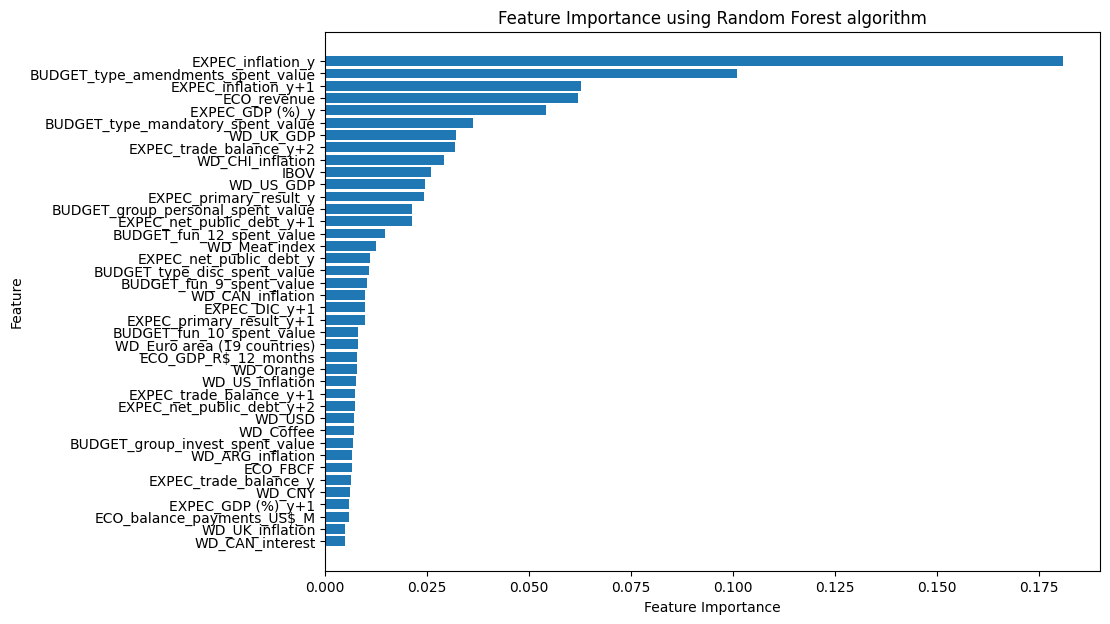

In [8]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=1000, random_state=42) # 1000 trees
model.fit(X_train, y_train)

# Obtain feature importance
feature_importances = model.feature_importances_

# Create a DataFrame to visualize feature importance
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plot_selected_features(features_df, number_of_features, 'Feature Importance using Random Forest algorithm')

# subset df_raw with the most important features
data_cleaned_RF = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_RF.to_csv('../data/data_cleaned_RF.csv', index=True)


### Feature Importance using Lasso model

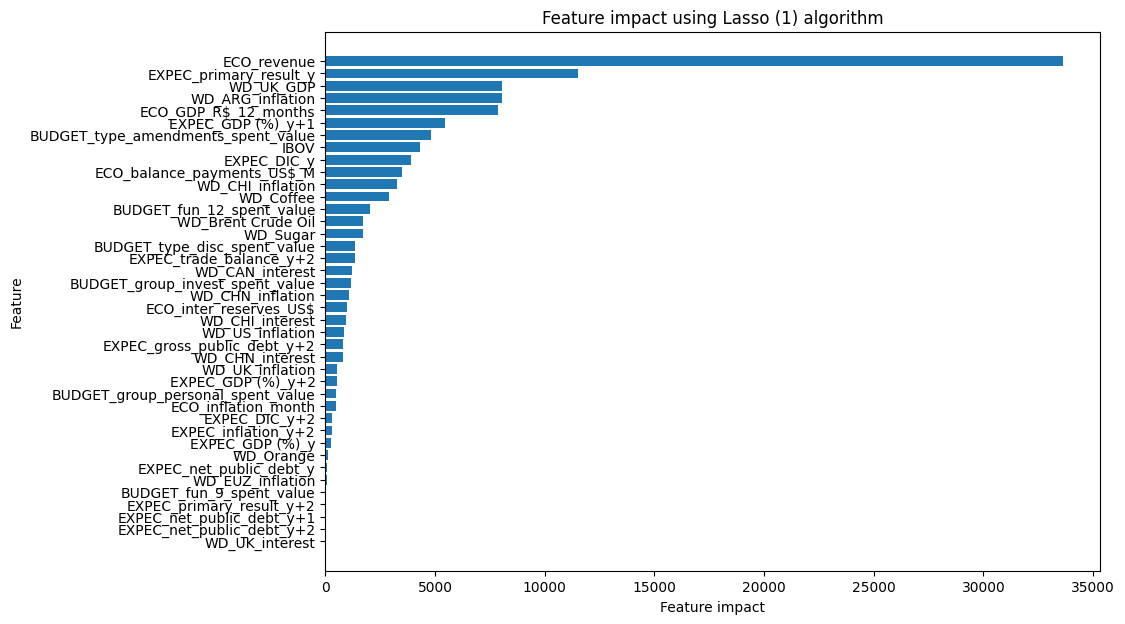

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define some alphas to test which one is the best
alphas = [10, 100, 150, 165, 175, 185, 190, 195, 200, 202, 210, 215, 230, 250, 300, 500] # Alpha is the regularization parameter

# Initialize the LassoCV model
lasso_cv = LassoCV(alphas=alphas, max_iter = 10000000, cv=10, random_state=42) # 10-fold cross-validation, 10 million iterations
lasso_cv.fit(X_train_scaled, y_train)

# Get the coefficients of the model
features_df = pd.DataFrame(lasso_cv.coef_, X_train.columns, columns=['coefficients'])

# Order the coefficients by absolute value
features_df = features_df.abs().sort_values(by='coefficients', ascending=False)

# Make the index a column and rename it to "features"
features_df.reset_index(inplace=True)
features_df.rename(columns={'index':'Feature'}, inplace=True)

#Plot the most important features
plot_selected_features(features_df, number_of_features, 'Feature impact using Lasso (1) algorithm')

# subset df_raw with the most important features
data_cleaned_LASSO = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_LASSO.to_csv('../data/data_cleaned_LASSO.csv', index=True)

### Feature Importance using Recursive Feature Elimination - RFE

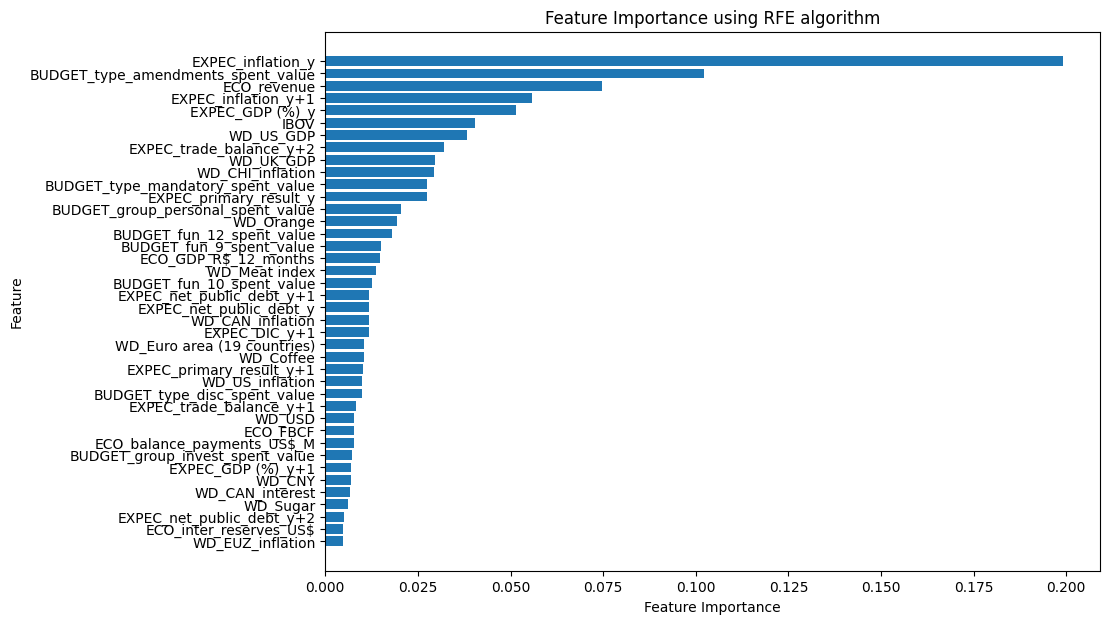

In [10]:
# Initialize the model
modelo = RandomForestRegressor()

# Initialize the RFE model
rfe = RFE(estimator=modelo, n_features_to_select=number_of_features)

# Fit the RFE model
rfe.fit(X_train, y_train)

# Check the most important features
seleced_variables = X_train.columns[rfe.support_]
coefficients = rfe.estimator_.feature_importances_

# Combine both in a dataframe called "features_df"
features_df = pd.DataFrame({'Feature': seleced_variables, 'Importance': coefficients})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot a bar chart 
plot_selected_features(features_df, number_of_features, 'Feature Importance using RFE algorithm')

# subset df_raw with the most important features
data_cleaned_RFE = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_RFE.to_csv('../data/data_cleaned_RFE.csv', index=True)
